# Financial AI Multi-Agent System with Vinagent

## Overview

In this tutorial, we will build a **Financial AI Multi-Agent System** using the Vinagent library. The system consists of four specialized agents working together in a pipeline:

```
User Query → Searcher Agent → Hypothesis Agent → Signal Builder Agent → Reporter Agent → Output
```

| Agent | Role |
|---|---|
| **Searcher Agent** | Gathers financial data and market news using web search and stock data tools |
| **Hypothesis Agent** | Analyzes the collected data and formulates investment hypotheses |
| **Signal Builder Agent** | Converts hypotheses into actionable trading signals with confidence scores |
| **Reporter Agent** | Generates a comprehensive visualization report with charts and recommendations |

### Prerequisites

- Vinagent >= 0.0.6
- API keys for OpenAI and Tavily (for web search)

## 1. Install Dependencies

In [30]:
%pip install vinagent==0.0.6.post3 --no-deps
%pip install langchain-core langchain-openai langchain-openai python-dotenv tavily-python yfinance plotly -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Configuration

First, let's set up our environment. You should define `OPENAI_API_KEY` and `TAVILY_API_KEY` in a `.env` file.

In [31]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv('.env'))

llm = ChatOpenAI(
    model="gpt-4o-mini"
)

print("LLM initialized successfully!")

LLM initialized successfully!


In [32]:
from datetime import datetime
from vinagent.register import primary_function

@primary_function
def get_current_time() -> str:
    """
    Get the current date and time. Use this to know 'today's' date.
    Returns:
        str: Current date and time in YYYY-MM-DD HH:MM:SS format.
    """
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("Custom time tool defined.")

Custom time tool defined.


## 3. Understanding the Multi-Agent Architecture

Vinagent's multi-agent system is built on three key concepts:

1. **`AgentNode`**: A proxy class that combines Vinagent's `Agent` (with LLM, tools, memory) and a graph `Node`. Each agent must implement the `exec(state)` method.

2. **`FlowStateGraph`**: Defines how agents are connected and the order of execution using the `>>` operator.

3. **`CrewAgent`**: Orchestrates the multi-agent system, compiling the graph and managing shared state.

The shared `State` dictionary allows agents to pass data to each other through the pipeline.

## 4. Define the Shared State

The state is a `TypedDict` that all agents share. It holds the conversation messages and intermediate results from each agent. The `Annotated` type with a reducer function tells the graph how to merge updates.

In [33]:
from typing import Annotated, TypedDict

# Reducer: appends new messages to the existing list
def append_messages(existing: list, update: str) -> list:
    return existing + [update]

class FinancialState(TypedDict):
    """Shared state across all financial agents."""
    messages: Annotated[list[str], append_messages]  # Conversation history
    search_results: str     # Raw search data from Searcher
    hypothesis: str         # Investment hypothesis from Hypothesis Agent
    signals: str            # Trading signals from Signal Builder
    report: str             # Final report from Reporter

print("FinancialState schema defined.")

FinancialState schema defined.


## 5. Define Agent Classes

Each agent extends `AgentNode` and implements an `exec(state)` method. This method:
- Reads from the shared state
- Calls `self.invoke(...)` to interact with its LLM
- Returns a dict that updates the shared state

### 5.1. Searcher Agent

The Searcher gathers raw data about a stock using web search and stock data tools.

In [34]:
from vinagent.multi_agent import AgentNode, CrewAgent
from vinagent.logger.logger import logging_message

class Searcher(AgentNode):
    """Gathers financial data and news about a stock."""
    @logging_message
    def exec(self, state: FinancialState) -> dict:
        # Get the user query from the latest message
        query = state["messages"][-1]["content"]
        # Use the agent's LLM + tools to search for data
        output = self.invoke(query)
        result_text = output.content if hasattr(output, 'content') else str(output)
        return {
            "messages": {"role": "Searcher", "content": output},
            "search_results": result_text
        }

print("Searcher agent class defined.")


Searcher agent class defined.


### 5.2. Hypothesis Agent

The Hypothesis Agent analyzes the search results and formulates investment hypotheses.

In [35]:
class HypothesisAgent(AgentNode):
    """Formulates investment hypotheses based on collected data."""
    @logging_message
    def exec(self, state: FinancialState) -> dict:
        # Build context from search results
        search_data = state.get("search_results", "No data available")
        prompt = (
            f"Based on the following financial data and news, "
            f"formulate clear investment hypotheses:\n\n"
            f"{search_data}"
        )
        output = self.invoke(prompt)
        result_text = output.content if hasattr(output, 'content') else str(output)
        return {
            "messages": {"role": "HypothesisAgent", "content": output},
            "hypothesis": result_text
        }

print("HypothesisAgent class defined.")


HypothesisAgent class defined.


### 5.3. Signal Builder Agent

The Signal Builder converts hypotheses into actionable trading signals with buy/sell/hold recommendations.

In [36]:
class SignalBuilder(AgentNode):
    """Converts hypotheses into actionable trading signals."""
    @logging_message
    def exec(self, state: FinancialState) -> dict:
        hypothesis = state.get("hypothesis", "No hypothesis available")
        search_data = state.get("search_results", "No data available")
        prompt = (
            f"Based on the following investment hypotheses and market data, "
            f"generate clear trading signals.\n\n"
            f"Hypotheses:\n{hypothesis}\n\n"
            f"Market Data:\n{search_data}"
        )
        output = self.invoke(prompt)
        result_text = output.content if hasattr(output, 'content') else str(output)
        return {
            "messages": {"role": "SignalBuilder", "content": output},
            "signals": result_text
        }

print("SignalBuilder agent class defined.")


SignalBuilder agent class defined.


### 5.4. Reporter Agent

The Reporter produces the final comprehensive report with visualizations and investment recommendations.

In [37]:
class Reporter(AgentNode):
    """Generates comprehensive financial report with visualizations."""
    @logging_message
    def exec(self, state: FinancialState) -> dict:
        search_data = state.get("search_results", "")
        hypothesis = state.get("hypothesis", "")
        signals = state.get("signals", "")
        prompt = (
            f"Create a comprehensive financial analysis report based on ALL the "
            f"following information. The report should use markdown format.\n\n"
            f"=== MARKET DATA ===\n{search_data}\n\n"
            f"=== INVESTMENT HYPOTHESES ===\n{hypothesis}\n\n"
            f"=== TRADING SIGNALS ===\n{signals}"
        )
        output = self.invoke(prompt)
        result_text = output.content if hasattr(output, 'content') else str(output)
        return {
            "messages": {"role": "Reporter", "content": output},
            "report": result_text
        }

print("Reporter agent class defined.")


Reporter agent class defined.


## 6. Instantiate the Agents

Now we create agent instances with their specific configurations: name, description, instruction, LLM, skills, and tools.

Each agent gets its own identity and specialized behavior through these parameters.

> **Note**: The `tools` parameter accepts module paths (e.g., `'vinagent.tools.websearch_tools'`). Vinagent auto-discovers and registers all `@primary_function` decorated functions from these modules.

In [38]:
import os
from customize_tools import fetch_stock_data_vn, visualize_stock_data_vn, plot_returns_vn


# --- 1. Searcher Agent ---
searcher = Searcher(
    name="searcher",
    description="A financial research agent that gathers market data, stock prices, and financial news.",
    instruction=(
        "You are a financial research analyst. Use the get_current_time tool to find out 'today's' date, then gather comprehensive data about the given stock or financial topic. "
        " "
        "If fetch_stock_data_vn returns no data, DO NOT retry it indefinitely; instead, try a search_api query to confirm the correct symbol or verify current news. "
        "Use the search tool to find the latest news, analyst opinions, and market sentiment. "
        "Use stock data tools to fetch historical price data."
        "Use the get_current_time tool to find out 'today's' date. When fetching stock data, "
        "always set end_date to today's date and start_date to a reasonable past date "
        "(e.g., 5 years before today) to ensure the data is up-to-date and covers a sufficient period."

    ),
    llm=llm,
    skills=[
        "Search for financial news and market data",
        "Fetch and analyze stock price data",
        "Summarize market sentiment"
    ],
    tools=[
        'vinagent.tools.websearch_tools',
    ],
)

# --- 2. Hypothesis Agent ---
hypothesis_agent = HypothesisAgent(
    name="hypothesis_agent",
    description="An analyst agent that formulates investment hypotheses from research data.",
    instruction=(
        "You are a financial research analyst. Use the get_current_time tool to find out 'today's' date, then gather comprehensive data about the given stock or financial topic. "
        " "
        "If fetch_stock_data_vn returns no data, DO NOT retry it indefinitely; instead, try a search_api query to confirm the correct symbol or verify current news. "
        "Use the search tool to find the latest news, analyst opinions, and market sentiment. "
        "Use stock data tools to fetch historical price data."

    ),
    llm=llm,
    skills=[
        "Formulate data-driven investment hypotheses",
        "Identify bull and bear scenarios",
        "Assess risk factors"
    ],
)

# --- 3. Signal Builder Agent ---
signal_builder = SignalBuilder(
    name="signal_builder",
    description="A quantitative agent that converts hypotheses into actionable trading signals.",
    instruction=(
        "You are a financial research analyst. Use the get_current_time tool to find out 'today's' date, then gather comprehensive data about the given stock or financial topic. "
        " "
        "If fetch_stock_data_vn returns no data, DO NOT retry it indefinitely; instead, try a search_api query to confirm the correct symbol or verify current news. "
        "Use the search tool to find the latest news, analyst opinions, and market sentiment. "
        "Use stock data tools to fetch historical price data."

    ),
    llm=llm,
    skills=[
        "Generate BUY/SELL/HOLD signals",
        "Calculate risk/reward ratios",
        "Set target prices and stop-losses"
    ],
)

# --- 4. Reporter Agent ---
reporter = Reporter(
    name="reporter",
    description="A reporting agent that creates comprehensive financial analysis reports with visualizations.",
    instruction=(
        "You are a financial research analyst. Use the get_current_time tool to find out 'today's' date, then gather comprehensive data about the given stock or financial topic. "
        " "
        "If fetch_stock_data_vn returns no data, DO NOT retry it indefinitely; instead, try a search_api query to confirm the correct symbol or verify current news. "
        "Use the search tool to find the latest news, analyst opinions, and market sentiment. "
        "Use stock data tools to fetch historical price data."

    ),
    llm=llm,
    skills=[
        "Write professional financial reports",
        "Create data visualizations",
        "Summarize complex analysis clearly"
    ],
    tools=[],
)

print("All 4 agents instantiated successfully!")
# Register the custom tool manually for all agents
for agent in [searcher, hypothesis_agent, signal_builder, reporter]:
    agent.tools_manager.register_function_tool(get_current_time)
    agent.tools_manager.register_function_tool(fetch_stock_data_vn)
    agent.tools_manager.register_function_tool(visualize_stock_data_vn)
    agent.tools_manager.register_function_tool(plot_returns_vn)
print("Custom tool registered for all agents.")


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.register.tool:Registered search_api:
{'tool_name': 'search_api', 'arguments': 'query: Union[str, dict[str, str]]', 'return': 'The answer from search query', 'docstring': 'Search for an answer from a query string\n    Args:\n        query (dict[str, str]):  The input query to search\n    Returns:\n        The answer from search query', 'dependencies': ['os', 'dotenv', 'tavily', 'dataclasses', 'typing', 'vinagent'], 'module_path': 'vinagent.tools.websearch_tools', 'tool_type': 'module', 'tool_call_id': 'tool_409a911a-b1c3-40b0-9f2d-4157b4ad020'}
INFO:vinagent.register.tool:Completed registration for module vinagent.tools.websearch_tools
INFO:vinagent.register.tool:Registered tool: get_current_time (runtime)
INFO:vinagent.register.tool:Registered tool: fetch_stock_data_vn (runtime)
INFO:vinagent.register.tool:Registered tool: visualize_stock_data_vn (runtime)
INFO:vinagent.register.too

All 4 agents instantiated successfully!
Custom tool registered for all agents.


## 7. Build the Multi-Agent Crew

Now we wire everything together using `CrewAgent` with a `FlowStateGraph`. The `>>` operator defines the execution flow:

```
searcher >> hypothesis_agent >> signal_builder >> reporter >> END
```

This creates a **linear pipeline** where each agent's output feeds into the next.

In [39]:
from vinagent.graph.operator import FlowStateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

class ConfigSchema(TypedDict):
    user_id: str

# Build the crew with a linear flow
crew = CrewAgent(
    llm=llm,
    checkpoint=MemorySaver(),
    graph=FlowStateGraph(FinancialState, config_schema=ConfigSchema),
    flow=[
        searcher >> hypothesis_agent,
        hypothesis_agent >> signal_builder,
        signal_builder >> reporter,
        reporter >> END,
    ]
)

print("Financial multi-agent crew assembled!")

Financial multi-agent crew assembled!


### Visualize the Agent Graph

We can inspect the compiled graph to see the execution flow:

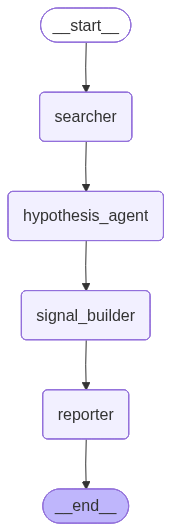

In [40]:
# Display the compiled graph
crew.compiled_graph

## 8. Run the Financial Analysis

Let's invoke the multi-agent system with a financial query. The query will flow through all 4 agents:

1. **Searcher** gathers data about the stock
2. **Hypothesis Agent** formulates investment theses
3. **Signal Builder** generates trading signals
4. **Reporter** creates the final report

In [41]:
query = """Analyze FPT (FPT) stock. 
Research the current market situation, recent news, and provide investment recommendations."""

result = crew.invoke(
    query=query,
    user_id="analyst",
    thread_id=3
)


INFO:vinagent.multi_agent.crew:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:I'am chatting with unknown_user
INFO:vinagent.agent.agent:Tool calling iteration 1/10


{'input': {'messages': {'role': 'user', 'content': 'Analyze FPT (FPT) stock. \nResearch the current market situation, recent news, and provide investment recommendations.'}}, 'config': {'configurable': {'user_id': 'analyst'}, 'thread_id': 3}}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'get_current_time', 'tool_type': 'function', 'arguments': {}, 'module_path': '__runtime__'}
INFO:vinagent.register.tool:Completed executing function tool get_current_time({})
INFO:vinagent.agent.agent:Tool calling iteration 2/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'fetch_stock_data_vn', 'tool_type': 'function', 'arguments': {'symbol': 'FPT', 'start_date': '2021-02-28', 'end_date': '2026-02-28', 'interval': '1d'}, 'module_path': '__runtime__'}
INFO:vinagent.register.tool:Completed executing function tool fetch_stock_data_vn({'symbol': 'FPT', 'start_date': '2021-02-28', 'end_date': '2026-02-28', 'interval': '1d'})
INFO:vinagent.agent.agent:Tool calling iteration 3/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/ch

Error fetching data for FPT: RetryError[<Future at 0x1d0a261f920 state=finished raised ValueError>]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'search_api', 'tool_type': 'module', 'arguments': {'query': 'latest news on FPT Corporation stock performance and analyst opinions'}, 'module_path': 'vinagent.tools.websearch_tools'}
INFO:vinagent.register.tool:Completed executing module tool search_api({'query': 'latest news on FPT Corporation stock performance and analyst opinions'})
INFO:vinagent.agent.agent:Tool calling iteration 4/10
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 4 iterations.
INFO:vinagent.logger.logger:

============ HypothesisAgent Response ============
{'messages': {'role': 'HypothesisAgent', 'content': AIMessage(content='Based on the recent financial data and news on FPT Corporation:\n\n1. **Investment Hypothesis**: FPT Corporation is positioned for gr

## 9. View Agent-by-Agent Outputs

Let's examine what each agent contributed to the analysis:

In [42]:
# Print each agent's response
for msg in result['messages']:
    role = msg['role']
    content = msg['content'].content if hasattr(msg['content'], 'content') else msg['content']
    # Truncate long outputs for readability
    preview = content[:500] + '...' if len(content) > 500 else content
    print(f"{'='*60}")
    print(f"  {role}")
    print(f"{'='*60}")
    print(preview)
    print()

  user
Analyze FPT (FPT) stock. 
Research the current market situation, recent news, and provide investment recommendations.

  Searcher
FPT Corporation's stock (FPT) has demonstrated moderate performance recently. It has underperformed the broader market but has matched the returns of its industry peers. In 2025, FPT reported an 11.6% increase in revenue. Analysts currently rate FPT as a "Buy," with a target price set at ₫122,413.92.

Given this information, an investment recommendation for FPT could be considered favorable due to its positive revenue growth and positive analyst outlook. However, investors should remain mindful ...

  HypothesisAgent
Based on the recent financial data and news on FPT Corporation:

1. **Investment Hypothesis**: FPT Corporation is positioned for growth with a favorable outlook. The reported 11.6% increase in revenue for 2025 indicates solid business performance. Coupled with a current analyst rating of "Buy" and the target price of ₫122,413.92, FPT stoc

## 10. Display the Final Report

The Reporter agent's output is a comprehensive markdown report. Let's render it:

In [43]:
from IPython.display import Markdown, display

# Render the final report as formatted markdown
report = result.get('report', 'No report generated.')
display(Markdown(report))

# Financial Analysis Report for FPT Corporation

**Date:** 2026-02-28

## Market Data
FPT Corporation's stock (FPT) has shown moderate performance recently. It has underperformed the broader market but has managed to match the returns of its industry peers. In 2025, FPT reported an **11.6% increase in revenue**. Analysts currently have a rating of **"Buy"** for FPT, with a target price set at **₫122,413.92**.

**Investment Recommendation:** Considering the positive revenue growth and the current favorable analyst outlook, an investment in FPT could be viewed positively. However, investors should consider the stock's recent underperformance relative to the broader market and assess their risk tolerance.

## Investment Hypotheses

1. **Investment Hypothesis:** FPT Corporation is positioned for growth with a favorable outlook. The reported revenue increase indicates robust business performance. With an analyst rating of "Buy" and a target price of ₫122,413.92, there appears to be significant upside potential for FPT stock.

2. **Bull Scenario:** If FPT continues to grow its revenue and capture more market share, the stock may reach or exceed its target price. Favorable market conditions and sustained positive analyst sentiment could further enhance price appreciation.

3. **Bear Scenario:** Ongoing underperformance against the broader market may signal potential challenges that could impede FPT's growth. If revenue does not meet expectations or if market conditions worsen, the stock may decline, leading to potential analyst downgrades.

4. **Risk Factors:** Investors should be cautious regarding the risk associated with FPT's recent underperformance against the wider market. External conditions, competitive pressures, and overall economic factors must be carefully monitored.

Given the favorable growth outlook accompanied by recent trading challenges, investors need to evaluate their risk tolerance before contemplating investments in FPT Corporation.

## Trading Signals

1. **Trading Signal:** **BUY**
   - The analyst rating reflects a **"Buy"** opinion on FPT with strong expected upside to ₫122,413.92.

2. **Risk/Reward Ratio:**
   - **Entry Price:** ₫92.90 (recent closing price as of February 27, 2026)
   - **Target Price:** ₫122,413.92
   - **Potential Reward:** ₫122,413.92 - ₫92.90 = ₫122,321.02
   - **Suggested Stop-Loss:** ₫89.00
   - **Potential Risk:** ₫92.90 - ₫89.00 = ₫3.90
   - **Risk/Reward Ratio:** Approximately **30:1**.

3. **Target Prices:**
   - **Short Term (6 months):** ₫105,100
   - **Medium Term (12 months):** ₫115,000
   - **Long Term (18 months):** ₫122,413.92 (aligned with analyst target price)

4. **Stop-Loss Recommendation:**
   - Set the stop-loss at **₫89.00** to mitigate substantial risk.

**Investor Advisory:** Regular monitoring of market conditions is advisable, alongside a reevaluation of positions that consider both FPT's revenue growth trajectory and external risk factors.

## 11. Examining Individual Pipeline Outputs

We can also inspect the intermediate results from each agent:

In [44]:
# View Search Results
print("=" * 50)
print("SEARCH RESULTS")
print("=" * 50)
search_results = result.get('search_results', 'N/A')
print(search_results[:1000] if len(search_results) > 1000 else search_results)
print()

SEARCH RESULTS
FPT Corporation's stock (FPT) has demonstrated moderate performance recently. It has underperformed the broader market but has matched the returns of its industry peers. In 2025, FPT reported an 11.6% increase in revenue. Analysts currently rate FPT as a "Buy," with a target price set at ₫122,413.92.

Given this information, an investment recommendation for FPT could be considered favorable due to its positive revenue growth and positive analyst outlook. However, investors should remain mindful of its recent underperformance relative to the broader market and evaluate their risk appetite.



In [45]:
# View Hypotheses
print("=" * 50)
print("INVESTMENT HYPOTHESES")
print("=" * 50)
display(Markdown(result.get('hypothesis', 'N/A')))

INVESTMENT HYPOTHESES


Based on the recent financial data and news on FPT Corporation:

1. **Investment Hypothesis**: FPT Corporation is positioned for growth with a favorable outlook. The reported 11.6% increase in revenue for 2025 indicates solid business performance. Coupled with a current analyst rating of "Buy" and the target price of ₫122,413.92, FPT stock appears to have a strong upside potential.

2. **Bull Scenario**: If FPT continues to grow its revenue and enhances its market share, the stock may potentially reach or even exceed the target price of ₫122,413.92. Positive market conditions and continued favorable analyst sentiment could contribute to significant price appreciation.

3. **Bear Scenario**: Continuous underperformance against the broader market may indicate underlying issues that could hinder FPT's growth. Should revenue fail to meet expectations or if market conditions deteriorate, the stock might not perform as forecast, leading to a decline in price or analyst downgrades.

4. **Risk Factors**: Investors should be cautious of the risk associated with the company's recent underperformance against the broader market. External market conditions, competition, and economic factors may impact FPT's performance and should be closely monitored.

Given the positive growth outlook alongside recent challenges, investors should assess their risk tolerance before making investment decisions regarding FPT Corporation.

In [46]:
# View Trading Signals
print("=" * 50)
print("TRADING SIGNALS")
print("=" * 50)
display(Markdown(result.get('signals', 'N/A')))

TRADING SIGNALS


Based on the provided information, here are the trading signals and analysis for FPT Corporation:

1. **Trading Signal**: **BUY**
   - Given the analyst rating of "Buy" and the target price of ₫122,413.92, FPT stock shows strong upside potential.

2. **Risk/Reward Ratio**: 
   - Entry Price: Based on the most recent closing price of ₫92.90 (as of February 27, 2026).
   - Target Price: ₫122,413.92
   - Potential Reward: ₫122,413.92 - ₫92.90 = ₫122,321.02
   - Suggested Stop-Loss: Set at ₫89.00 to limit losses if the stock underperforms.
   - Potential Risk: ₫92.90 - ₫89.00 = ₫3.90
   - Risk/Reward Ratio: Symbolically, this is approximately 30:1.

3. **Target Prices**:
   - Short Term (6 months): ₫105,100
   - Medium Term (12 months): ₫115,000
   - Long Term (18 months): ₫122,413.92 (Analyst target price)
  
4. **Stop-Loss Recommendation**: 
   - Set at ₫89.00 to protect from significant downside risks.

Investors are encouraged to monitor market conditions closely and reassess their positions regularly, keeping the company's revenue growth and external risk factors in mind.

## 12. How It Works — Key Concepts

### Agent Definition Pattern

```python
class MyAgent(AgentNode): 
    @logging_message
    def exec(self, state: MyState) -> dict:
        # 1. Read from shared state
        data = state["some_field"]
        
        # 2. Call LLM (with tools if configured)
        output = self.invoke(data)
        
        # 3. Return updates to shared state
        return {
            "messages": {"role": "MyAgent", "content": output},
            "some_field": output.content
        }
```

### Flow Definition

```python
# Linear pipeline
flow = [
    agent_a >> agent_b,
    agent_b >> agent_c,
    agent_c >> END,
]

# Branching (with branching() method)
flow = [
    supervisor >> {
        "option_a": agent_a,
        "option_b": agent_b,
    },
    agent_a >> END,
    agent_b >> END,
]
```

### Key Takeaways

1. **Modularity**: Each agent is self-contained with its own LLM, tools, and instruction
2. **Shared State**: Agents communicate through a typed state dictionary
3. **Specialization**: Each agent focuses on one task (search, analyze, signal, report)
4. **Composability**: The `>>` operator makes it easy to rewire the pipeline
5. **Tool Integration**: Agents can use tools like web search and stock data APIs

## 13. Next Steps

You can extend this system by:

- **Adding more tools**: Custom stock screeners, technical analysis indicators, financial statement parsers
- **Branching logic**: Use `branching()` to route different stock types to specialized agents
- **Memory**: Add persistent memory so the system remembers previous analyses
- **Human-in-the-loop**: Use `UserFeedback` nodes to let analysts approve/reject hypotheses before signal generation
- **Guardrails**: Add input/output guardrails to validate financial claims and prevent hallucinations